In [1]:
#Load libraries

import glob
import os

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.lines import Line2D

import statsmodels.api as sm
from scipy import stats

import iris
import iris.quickplot as qplt
import iris.analysis
import iris.coord_categorisation as icoca
from iris.util import mask_cube_from_shapefile
from iris.util import promote_aux_coord_to_dim_coord

import cartopy.io.shapereader as shpreader

import pandas as pd
import seaborn as sns

from dataclasses import dataclass

from iris.util import unify_time_units
from iris.util import equalise_attributes

import cmocean

import warnings

import pickle

In [2]:
#Load custom functions

from Cube_Functions import *
from Plot_Functions import *
from Climate_Functions import *
from Stats_Functions import *

In [3]:
import dask.optimization

# Patch the missing class
if not hasattr(dask.optimization, 'SubgraphCallable'):
    class SubgraphCallable:
        def __init__(self, *args, **kwargs):
            pass
    dask.optimization.SubgraphCallable = SubgraphCallable


In [4]:
#Models with available data

models = ['ACCESS-ESM1-5', #only sidmassevapsubl for Mid-Holocene (!)
        ###'AWI-ESM-1-1-LR',  # - doesn't have SSP585 ###Needs regrdding, was running in to memory issues
        'CESM2',  #  ### - SSP585 different variant
        'CNRM-CM6-1',  # - SSP585 different variant
        'EC-Earth3-LR',  # - SSP585 is the veg version (EC-Earth3-Veg-LR) ###needs regridding
        'EC-Earth3', ##New one, whoop, whoop!
        #'FGOALS-f3-L',  #     Can't find siconc for piControl, but has it for lig127k
        #'FGOALS-g3',  # Unrealistically highh SIA for the whole of this century
        'HadGEM3-GC3.1-LL',
        'IPSL-CM6A-LR', ###
        'MIROC-ES2L',  # - SSP585 different variant
        'NESM3',  # ###
        'NorESM1-F',  # - doesn't have SSP585
        'NorESM2-LM']  #

#models which have sithick as well. 
models = ['ACCESS-ESM1-5', 
        ###'AWI-ESM-1-1-LR',  # Needs regridding, as it's an unstructured mesh
        'CESM2',  #  ### - SSP585 different variant
        ###'CNRM-CM6-1',  # - No sithick for piControl, but has it for lig127k
        'EC-Earth3-LR',  # 
        'EC-Earth3',
        #'FGOALS-f3-L',  #     Can't find siconc for piControl, but has it for lig127k
        #'FGOALS-g3',  # Unrealistically highh SIA for the whole of this century
        'HadGEM3-GC3.1-LL',
        'IPSL-CM6A-LR',
        'MIROC-ES2L',
        'NESM3',
        'NorESM1-F']
        #'NorESM2-LM']  # ### No sithick for lig127k

#models with ssp585
ssp585_models = ['ACCESS-ESM1-5',  
        'CESM2',  
        'CNRM-CM6-1', 
        'IPSL-CM6A-LR',
        'MIROC-ES2L', 
        'NESM3', 
        'NorESM2-LM'] 



In [5]:
#Main parameters

experiment = 'lig127k'
control = 'piControl'

root_path = '/gws/nopw/j04/pmip4_vol1/public/matt/data/'

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


t_seconds = 30 * 24 * 60 * 60  #seconds in a month

store = False
create = False
add = False #add new model(s) to existing stored dictionaries. create must be 'True'

if add:
    create = True

variable_storage = 'Energy_Budget_vars.pkl'

In [6]:
#cmor variables names, with the required factor.
#siconc factor is to change to Mkm^2 from m^2
#bearing in mind it is from 0 to 100 not 0 to 1 per cell
#radiation factors are 1 for energy in to the surface, -1 otherwise

energy_variables_dict = {'rsus':-1, 
             'rsds':1,
             'rlds':1,
             'rlus':-1,
             'hfss':-1,
             'hfls':-1}

si_variables_dict = {'siconc': 1e14}

#define variables for albedo
downwelling = 'rsds'
upwelling = 'rsus'
siconc = 'siconc'
siconc_threshold = 15.0
albedo_variations = False

energy_variables = energy_variables_dict.keys()
si_variables = si_variables_dict.keys()


In [7]:
#Constraints to set the region of interest

con = iris.Constraint(latitude=lambda lat: 59.5 <= lat <= 90)

time_con = iris.Constraint(year=lambda y:np.logical_and(y>=2035,y<2045))  #time_constraint. Not used anywhere yet.

ocean_shp_reader = shpreader.Reader(shpreader.natural_earth(resolution="110m", category="physical", name="ocean"))
ocean_list = []
for ocean in ocean_shp_reader.records():
    ocean_list.append(ocean.geometry)
ocean_shp = ocean_list[1]

shape = ocean_shp

In [8]:

idiot = True
if idiot:
    warnings.filterwarnings("ignore")

In [9]:
def create_dicts(experiment):
    experiment_energy_dict = {}
    experiment_si_dict = {}
    experiment_albedo_dict = {}
    
    for model in models:
        print(model)
        energy_dict = {}
        for var in energy_variables:
            print(var)
            path = create_path(model, experiment, var, root_path)
            cube = get_cube(path, var, con, shape)
            monthly_data = get_monthly_data(cube, 'MEAN') / energy_variables_dict[var]
            energy_dict[var] = monthly_data
        experiment_energy_dict[model] = energy_dict
        
        si_dict = {}
        for var in si_variables:
            print(var)
            path = create_path(model, experiment, var, root_path)
            cube = get_cube(path, var, con, shape)
            monthly_data = get_monthly_data(cube, 'SUM') / si_variables_dict[var]
            si_dict[var] = monthly_data
        experiment_si_dict[model] = si_dict
    
        albedo_dict = {}
    
        downwelling_path = create_path(model, experiment, downwelling, root_path)
        downwelling_cube = get_cube(downwelling_path, downwelling, con, shape)
        
        upwelling_path = create_path(model, experiment, upwelling, root_path)
        upwelling_cube = get_cube(upwelling_path, upwelling, con, shape)
        
        siconc_path = create_path(model, experiment, siconc, root_path)
        siconc_cube = get_cube(siconc_path, siconc, con, shape)
        
        mask = siconc_cube.data >= siconc_threshold
    
        monthly_downwelling = get_monthly_data(downwelling_cube, 'sum')
        monthly_upwelling = get_monthly_data(upwelling_cube, 'sum')
        albedo_dict['area_albedo'] = monthly_upwelling / monthly_downwelling
    
        if albedo_variations:
            masked_downwelling_cube = mask_cube(downwelling_cube, mask)
            masked_upwelling_cube = mask_cube(upwelling_cube, mask)
            monthly_masked_downwelling = get_monthly_data(masked_downwelling_cube, 'sum')
            monthly_masked_upwelling = get_monthly_data(masked_upwelling_cube, 'sum')
            albedo_dict['sicell_albedo'] = monthly_masked_upwelling / monthly_masked_downwelling
    
        experiment_albedo_dict[model] = albedo_dict
    return experiment_energy_dict, experiment_si_dict, experiment_albedo_dict

In [10]:
# if create:
#     experiment_energy_dict, experiment_si_dict, experiment_albedo_dict = create_dicts(experiment)
# else:
#     %store -r experiment_energy_dict
#     %store -r experiment_si_dict
#     %store -r experiment_albedo_dict

In [11]:
# if create:
#     control_energy_dict, control_si_dict, control_albedo_dict = create_dicts(control)
# else:
#     %store -r control_energy_dict
#     %store -r control_si_dict
#     %store -r control_albedo_dict

In [12]:
# if create:
#     anomaly_energy_dict = anomaly_dict(experiment_energy_dict, control_energy_dict)
#     anomaly_si_dict = anomaly_dict(experiment_si_dict, control_si_dict)
#     anomaly_albedo_dict = anomaly_dict(experiment_albedo_dict, control_albedo_dict)
# else:
#     %store -r anomaly_energy_dict
#     %store -r anomaly_si_dict
#     %store -r anomaly_albedo_dict

In [13]:
if create:    
    experiment_energy_dict, experiment_si_dict, experiment_albedo_dict = create_dicts(experiment)
    control_energy_dict, control_si_dict, control_albedo_dict = create_dicts(control)
    anomaly_energy_dict = anomaly_dict(experiment_energy_dict, control_energy_dict)
    anomaly_si_dict = anomaly_dict(experiment_si_dict, control_si_dict)
    anomaly_albedo_dict = anomaly_dict(experiment_albedo_dict, control_albedo_dict)
else:
    with open(variable_storage, 'rb') as f:
        recovered = pickle.load(f)
        experiment_energy_dict = recovered['experiment_energy_dict'] 
        experiment_si_dict = recovered['experiment_si_dict'] 
        experiment_albedo_dict = recovered['experiment_albedo_dict']
        control_energy_dict = recovered['control_energy_dict'] 
        control_si_dict = recovered['control_si_dict'] 
        control_albedo_dict = recovered['control_albedo_dict']
        anomaly_energy_dict = recovered['anomaly_energy_dict'] 
        anomaly_si_dict = recovered['anomaly_si_dict'] 
        anomaly_albedo_dict = recovered['anomaly_albedo_dict']
        

In [14]:
for model in models:
    experiment_energy_dict[model]['total'] = np.zeros(12)
    anomaly_energy_dict[model]['total'] = np.zeros(12)
    control_energy_dict[model]['total'] = np.zeros(12)
    experiment_energy_dict[model]['total'] = np.sum(np.stack(list(experiment_energy_dict[model].values()), axis=0), axis=0)
    anomaly_energy_dict[model]['total'] = np.sum(np.stack(list(anomaly_energy_dict[model].values()), axis=0), axis=0)
    control_energy_dict[model]['total'] = np.sum(np.stack(list(control_energy_dict[model].values()), axis=0), axis=0)

In [15]:
# if store:
#     %store experiment_energy_dict
#     %store experiment_si_dict
#     %store experiment_albedo_dict
    
#     %store control_energy_dict
#     %store control_si_dict
#     %store control_albedo_dict
    
#     %store anomaly_energy_dict
#     %store anomaly_si_dict
#     %store anomaly_albedo_dict



From Sea Ice Free script, models with low thickness / high slope:
- ACCESS-ESM1-5
- CESM2
- IPSL-CM6A-LR
- NESM3
- NorESM1-F

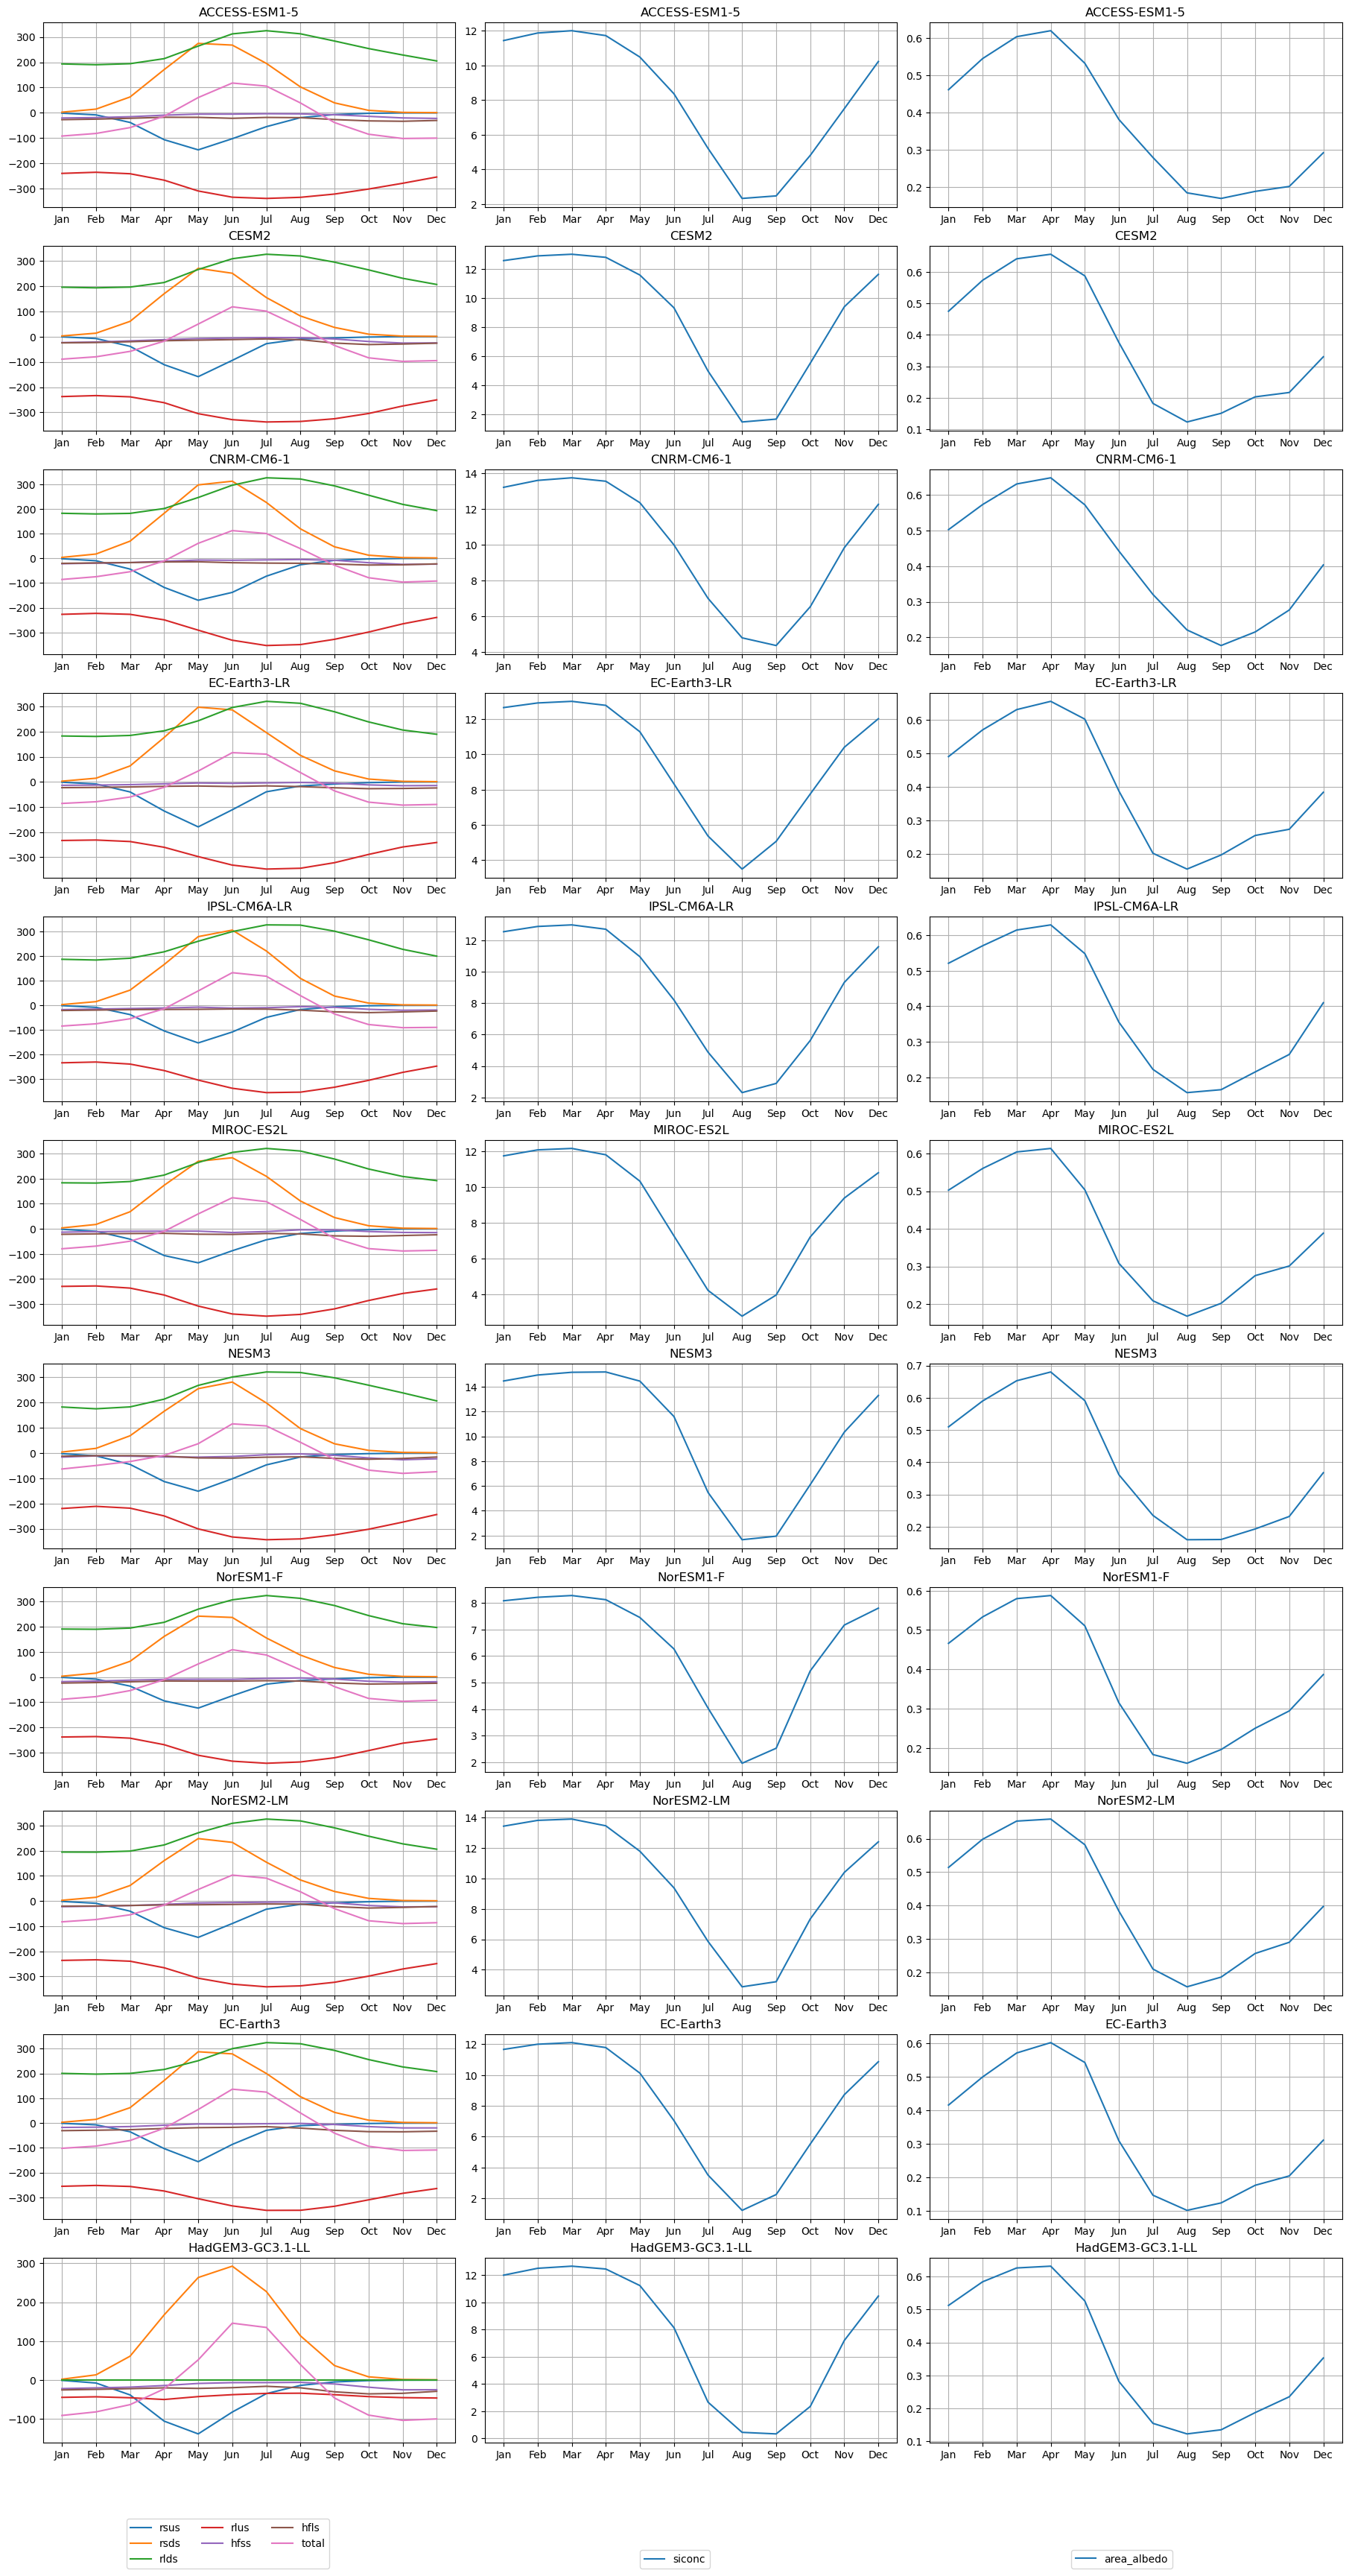

In [16]:
plot_grid(experiment_energy_dict, experiment_si_dict, experiment_albedo_dict, plot_sums = [False, False, False])

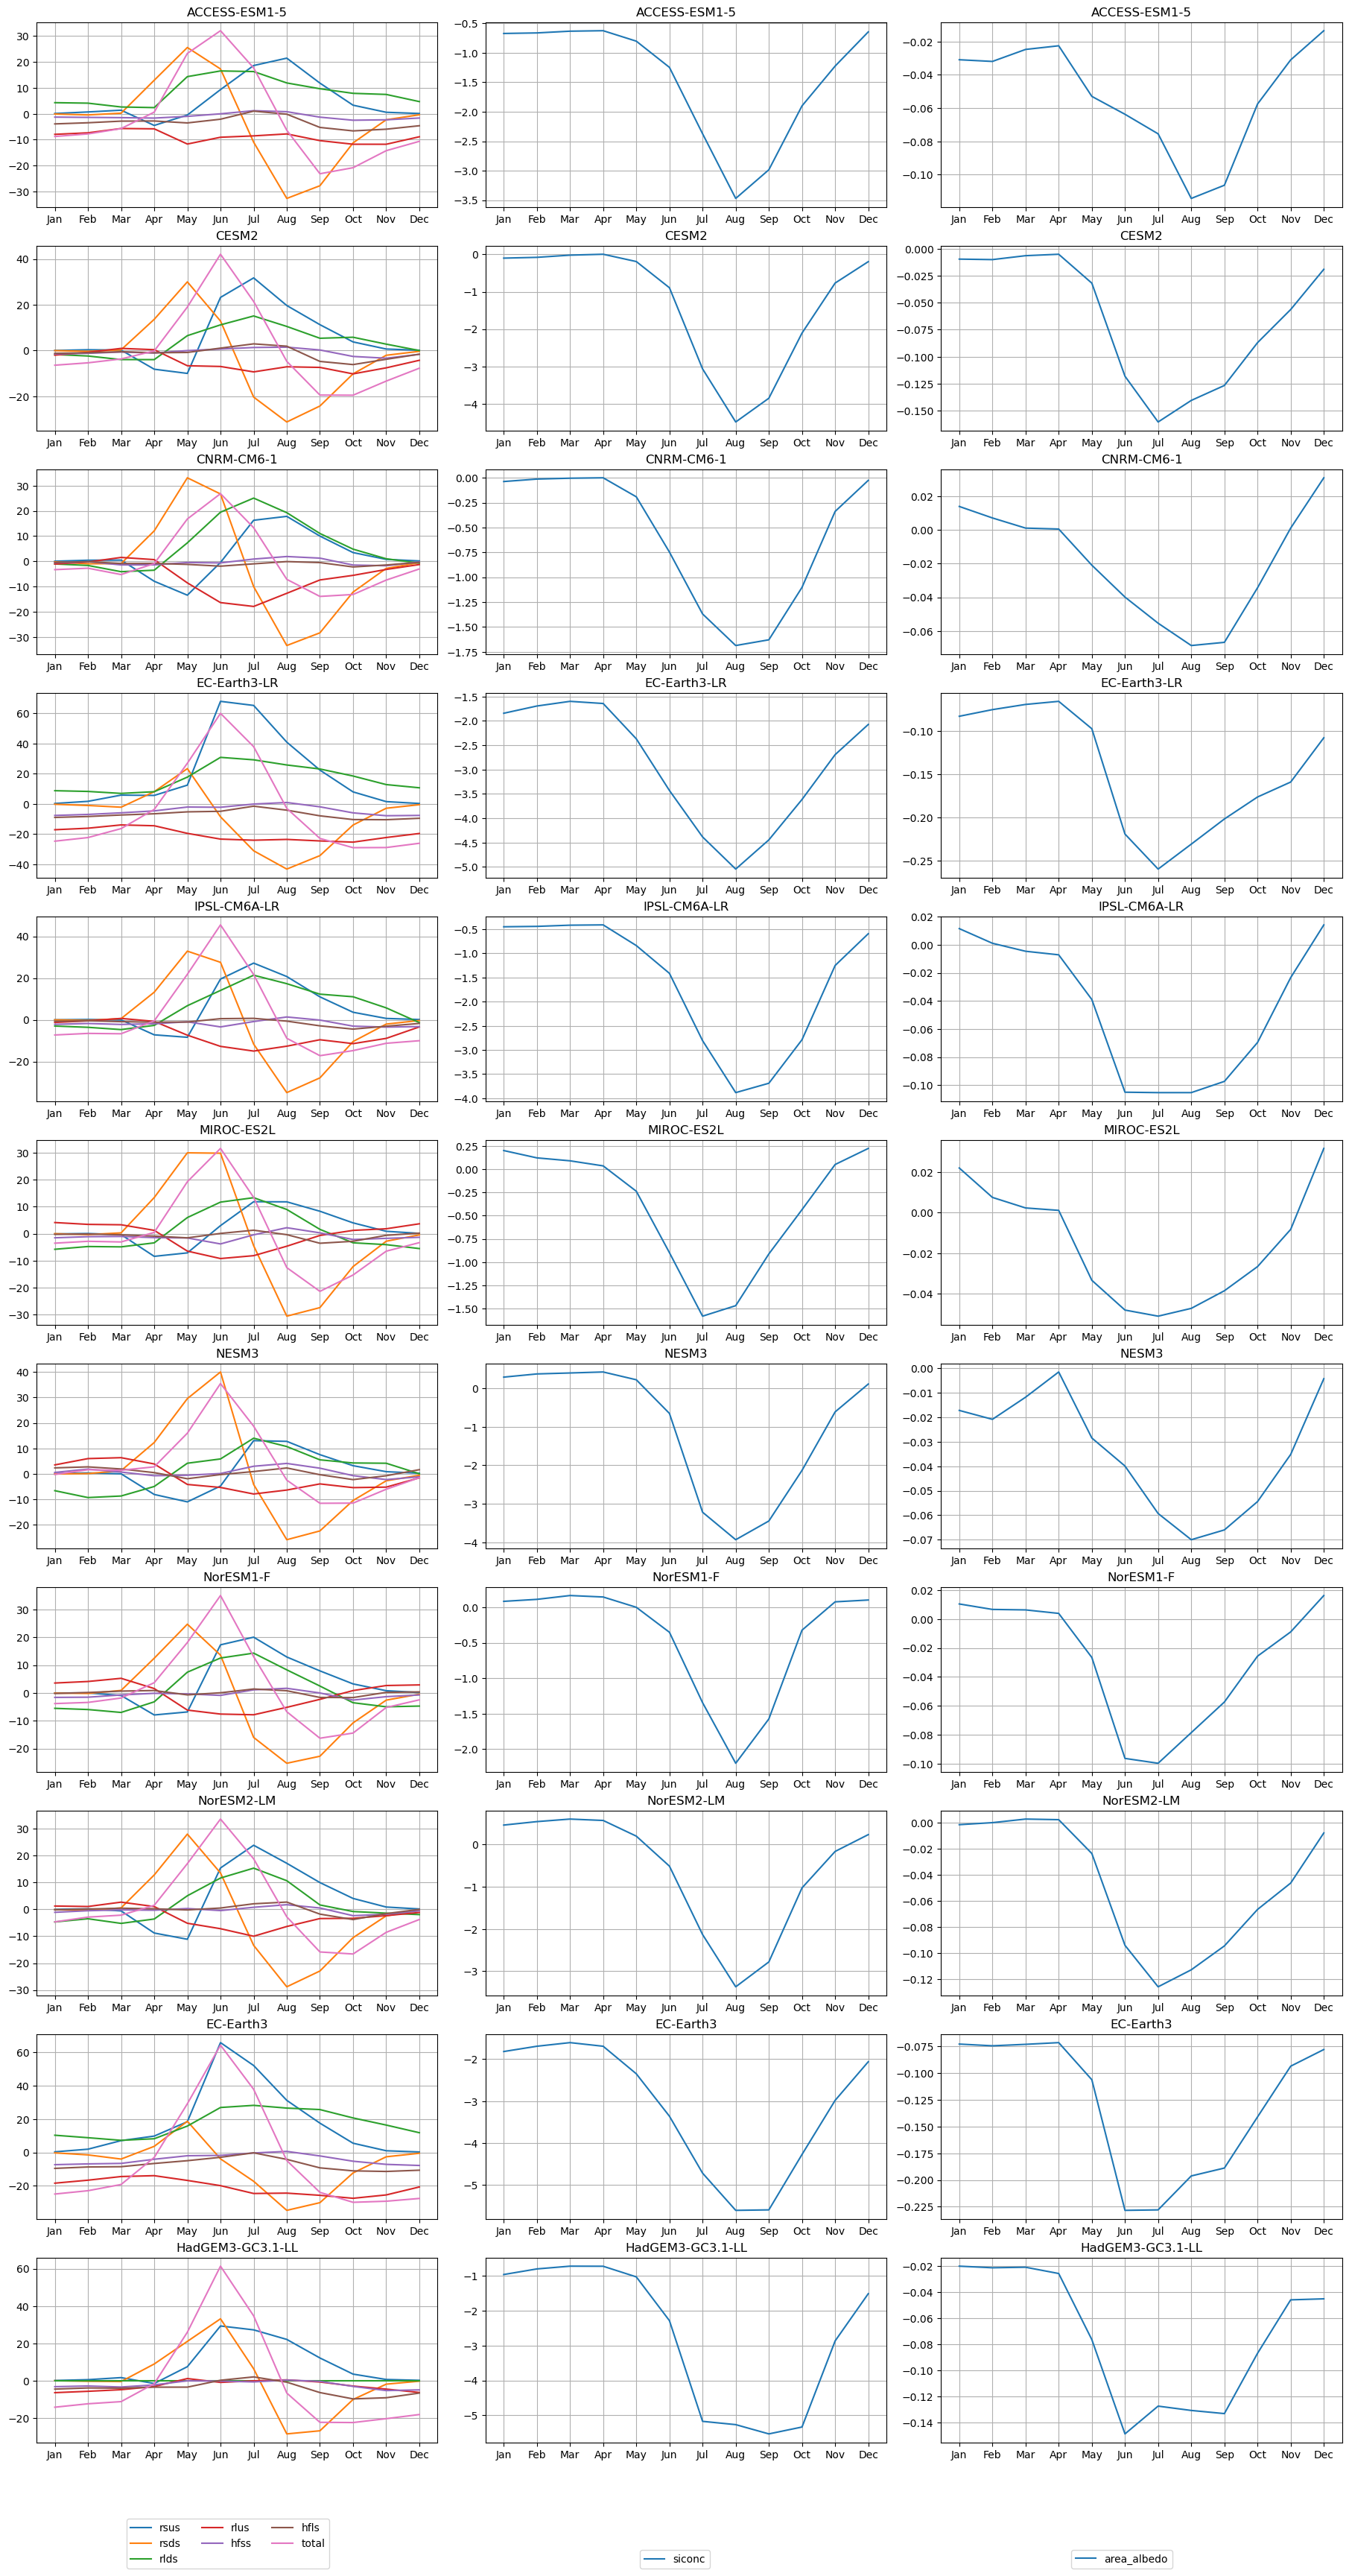

In [17]:
plot_grid(anomaly_energy_dict, anomaly_si_dict, anomaly_albedo_dict, plot_sums = [False, False, False])

In [18]:
corr_plot = 'anomaly' # anomaly experiment control
match corr_plot:
    case 'anomaly':
        energy_dict = anomaly_energy_dict 
        ice_dict = anomaly_si_dict
        albedo_dict = anomaly_albedo_dict
    case 'experiment':
        energy_dict = experiment_energy_dict 
        ice_dict = experiment_si_dict
        albedo_dict = experiment_albedo_dict 
    case 'control':
        energy_dict = control_energy_dict 
        ice_dict = control_si_dict
        albedo_dict = control_albedo_dict

In [19]:
#For this part, only do statisitcal analysis on those models that have ssp585
#since it's being used in the emerging constraint

#energy_dict = {k: v for k, v in energy_dict.items() if k in ssp585_models}
#ice_dict = {k: v for k, v in ice_dict.items() if k in ssp585_models}
#albedo_dict = {k: v for k, v in albedo_dict.items() if k in ssp585_models}
    

In [20]:
total_energy = []
positive_energy = []
max_energy = []
min_si = []
min_albedo = []
total_albedo = []
positive_rsds = []
positive_rlds = []
melt_season_energy = []
melt_season_rsds = []
summer_si = []
mayjune_energy = []
june_energy = []

for model in models:
    total_energy.append(np.trapz(energy_dict[model]['total'], dx=t_seconds)/1e6)   #Energy terms in MJ per m2
    mayjune_energy.append((energy_dict[model]['total'][3]+energy_dict[model]['total'][4]+energy_dict[model]['total'][5])/3.0)
    june_energy.append(energy_dict[model]['total'][5])
    positive_energy.append(np.trapz(np.maximum(energy_dict[model]['total'],0), dx=t_seconds)/1e6)
    positive_rsds.append(np.trapz(np.maximum(energy_dict[model]['rsds'],0), dx=t_seconds)/1e6)
    positive_rlds.append(np.trapz(np.maximum(energy_dict[model]['rlds'],0), dx=t_seconds)/1e6)
    max_energy.append(np.max(energy_dict[model]['total']))
    melt_season_energy.append(np.trapz(energy_dict[model]['total'][2:9], dx=t_seconds)/1e6)  #[2:9] i.e. Mar - Sep inclusive has the highest correlation with the SIA anomaly (see below). 
    melt_season_rsds.append(np.trapz(energy_dict[model]['rsds'][2:9], dx=t_seconds)/1e6)
    total_albedo.append(np.trapz(albedo_dict[model]['area_albedo'], dx=1.0/12.0))
    min_albedo.append(np.min(albedo_dict[model]['area_albedo']))
    min_si.append(np.min(ice_dict[model]['siconc']))
    #summer_si.append(np.mean(ice_dict[model]['siconc'][6:9]))
    
calculated_data = {'total_energy': total_energy,
    'positive_energy': positive_energy,
    'max_energy': max_energy,
    'melt_season_energy' : melt_season_energy,
    'melt_season_rsds' : melt_season_rsds,
    'positive_rsds': positive_rsds,
    'positive_rlds': positive_rlds,
    #'min_albedo': min_albedo,
    #'total_albedo': total_albedo,
    'min_si': min_si}#, 
    #'summer_si':summer_si}

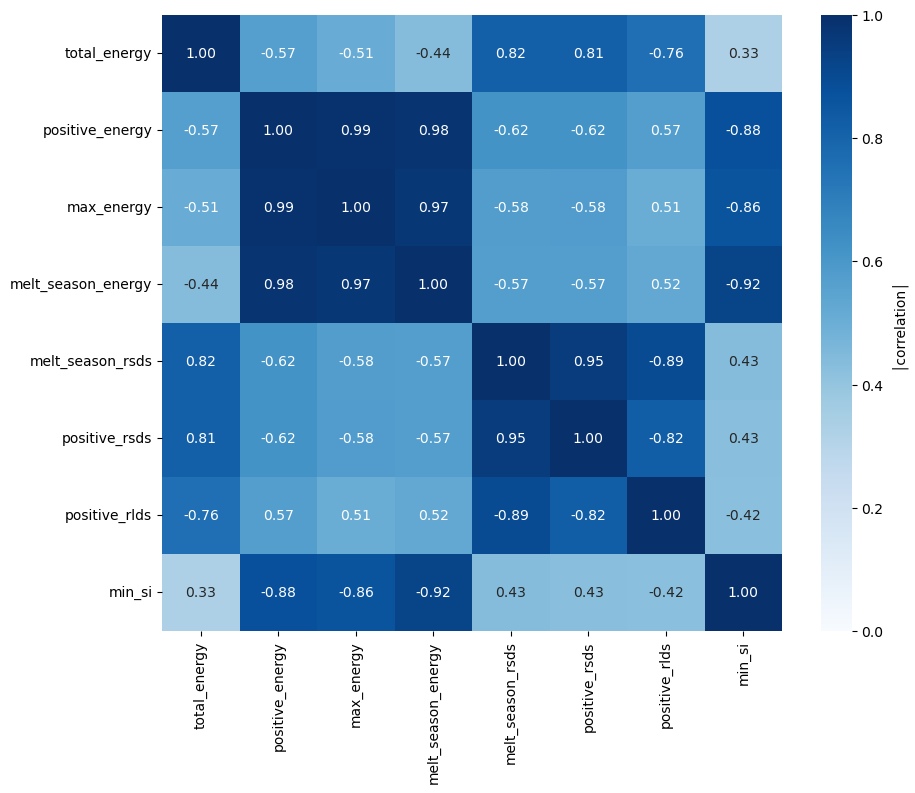

In [21]:
df   = pd.DataFrame(calculated_data)   
corr = df.corr() 

abs_corr = corr.abs()

vmax = abs_corr.values.max()

plt.figure(figsize=(10,8))
sns.heatmap(
    abs_corr,
    annot=corr,        # show the *signed* value in the cell
    fmt=".2f",
    cmap="Blues",   
    vmin=0,
    vmax=vmax,
    cbar_kws={"label": "│correlation│"}
)
plt.savefig('/home/users/matt/plots/' + 'corr_matrix' + '.png',
                    bbox_inches='tight')

In [54]:
def icefree_marker(pct):
    if pct < 0.1:
        return "o", 100  # circle
    elif pct < 10:
        return "^", 100  # triangle
    elif pct < 50:
        return 'D', 100 # square
    else:
        return "*", 150  # star

In [65]:
def scatter_models_bespoke(x, y, labels, xlabel=None, ylabel=None, title = None, save_name = None, x0 = None):
    #plots each data point as a different color, and creates a legend
    #Suitable for plotting different models, one data point per model
    #Plots a linear regression with 95% confidence interval.

    #if an x0 is provided, the expected y0 is calculated, and the PDF plotted

    #statistics are returned in a dictionary
    stats_dict = {}
    
    #linear regression and confidence intervals
    X = sm.add_constant(x)          
    model = sm.OLS(y, X).fit()      

    x_pred = np.linspace(30, 65, 100)
    X_pred = sm.add_constant(x_pred)
    pred = model.get_prediction(X_pred)
    pred_summary = pred.summary_frame(alpha=0.05)  

    
    unique_labels = sorted(set(labels))
    color_list = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    color_map = dict(zip(unique_labels, color_list))
    
    point_colors = [color_map[L] for L in labels]

    fig, ax = plt.subplots(figsize=(8,5))

    # Plot the data on `ax` instead of using plt.scatter
    sif_pct = [sif_percentages[m] for m in labels]
    for i, label in enumerate(labels):
        ax.scatter(x[i], y[i],
                c=color_map[label],
                s=icefree_marker(sif_pct[i])[1],
                edgecolor='k',
                marker=icefree_marker(sif_pct[i])[0])

    ax.grid(True, alpha=0.5)

    # Regression line and confidence interval
    ax.plot(x_pred, pred_summary["mean"], color='black', lw=2, label="Fit")
    ax.fill_between(x_pred,
                    pred_summary["mean_ci_lower"],
                    pred_summary["mean_ci_upper"],
                    color='gray',
                    alpha=0.3,
                    label="95% CI")

        # --- Build model handles (coloured markers with correct shapes) ---
    handles_models = []
    for model_name in unique_labels:
        # get the ice-free percentage for this model
        pct = sif_percentages[model_name]
        # get the corresponding marker
        shape = icefree_marker(pct)[0]
        size = icefree_marker(pct)[1]
        # create the legend handle
        handle = Line2D([0], [0],
                        marker=shape,
                        color='w',
                        markerfacecolor=color_map[model_name],
                        markeredgecolor='k',
                        markersize=10*(size/100),
                        label=model_name)
        handles_models.append(handle)

    # --- Build shape legend handles for % ice-free categories ---
    handles_shapes = [
        Line2D([], [], color='black', marker='o', linestyle='None',
            markersize=8, label='Never ice-free'),
        Line2D([], [], color='black', marker='^', linestyle='None',
            markersize=8, label='0–10% ice-free'),
        Line2D([], [], color='black', marker='D', linestyle='None',
            markersize=8, label='10–50% ice-free'),
        Line2D([], [], color='black', marker='*', linestyle='None',
            markersize=10, label='Majority ice-free')
    ]

    # --- Legend 2: ice-free shapes (inside plot) ---
    legend_shapes = ax.legend(
        handles_shapes,
        [h.get_label() for h in handles_shapes],
        title="% Ice-Free (${\mathit{lig127k}}$)",
        title_fontsize=12,
        loc='upper right',
        frameon=True,
        fontsize=10
    )
    legend_shapes.get_frame().set_alpha(0.8)  # optional transparency so it doesn't block points

    # --- Legend 1: models (below plot) ---
    legend_models = fig.legend(
        handles_models,
        [h.get_label() for h in handles_models],
        title="Model",
        title_fontsize=12,
        loc='lower center',
        bbox_to_anchor=(0.51, -0.22),  # adjust vertical position
        ncol=3,
        frameon=True,
        fontsize=12
    )


    

    # Labels and limits
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xlim(30, 65)
    ax.set_ylim(-7, -1)


    if save_name:
        plt.savefig(f'/home/users/matt/plots/{save_name}.png', bbox_inches='tight')

    plt.show()


        
    stats_dict['r_squared'] = model.rsquared
    stats_dict['intercept'], stats_dict['slope'] = model.params
    
    # Get fitted values (the model's prediction at each x)
    y_fitted = model.fittedvalues
    # Calculate RMSE
    rmse = np.sqrt(np.mean((y - y_fitted) ** 2))
    stats_dict['rmse'] = rmse
    
    if x0 is not None:
        # Get prediction results at x0
        X0 = np.array([[1.0, x0]])   # shape is now (1, 2): [const, x0]          
        pr = model.get_prediction(X0).summary_frame(alpha=0.05).iloc[0]

        mu = pr["mean"]                       # predicted mean
        se_mean = pr["mean_se"]               # standard error of the mean
        sigma_resid = np.sqrt(model.mse_resid)
        sigma_pred = np.sqrt(se_mean**2 + sigma_resid**2)

        # Build grid around the mean
        y_vals = np.linspace(mu - 4*sigma_pred,
                             mu + 4*sigma_pred, 200)
        
        #pdf = stats.norm.pdf(y_vals, loc=mu, scale=sigma_pred)

        df = model.df_resid
        pdf = stats.t.pdf(y_vals, df=df, loc=mu, scale=sigma_pred)
        
        # Plot
        plt.figure(figsize=(7,5))
        plt.plot(y_vals, pdf, lw=2)
        plt.title(f"PDF at {x0:.2f}")
        plt.xlabel(ylabel)
        plt.ylabel("Density")
        plt.grid(True, linestyle='--', alpha=0.5)
        if not save_name == None:
            plt.savefig('/home/users/matt/plots/'+save_name+'_pdf.png', bbox_inches='tight')
        plt.show()

        stats_dict['mean_at_x0'] = mu
        stats_dict['sd_at_x0'] = sigma_pred
        stats_dict['pdf'] = pdf


    
    return stats_dict

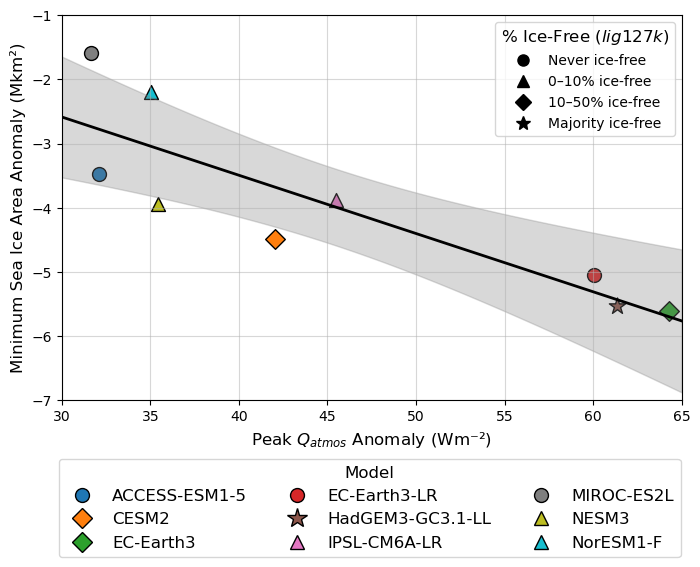

In [66]:
sif_percentages = {'ACCESS-ESM1-5': 0, 'CESM2': 19.14, 'EC-Earth3-LR': 0, 'EC-Earth3': 39, 'HadGEM3-GC3.1-LL': 93.14, 'IPSL-CM6A-LR': 3.82, 'MIROC-ES2L': 0, 'NESM3': 8, 'NorESM1-F': 2.5}
labels = models
x = np.array(max_energy)
y = np.array(min_si)
stats_dict = scatter_models_bespoke(x, y, labels, 
                            xlabel="Peak $Q_{\mathit{atmos}}$ Anomaly (Wm⁻²)", 
                            ylabel='Minimum Sea Ice Area Anomaly (Mkm²)', 
                            #title=('SIA vs Energy Anomaly'),
                            save_name = 'energy_sia_regression')

In [25]:
stats_dict

{'r_squared': np.float64(0.74341123939988),
 'intercept': np.float64(0.14056197145197782),
 'slope': np.float64(-0.09081839461928509),
 'rmse': np.float64(0.6678581439199831)}

In [26]:
print(np.sqrt(stats_dict['r_squared']))

0.8622129895796513


In [27]:
from scipy import stats
def correlation_stats(x, y):
    # Pearson correlation
    r, pval = stats.pearsonr(x, y)
    
    # R-squared
    r_squared = r**2
    
    # Fisher z-transform for CI
    n = len(x)
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = 1.96  # for 95%
    lo, hi = z - z_crit*se, z + z_crit*se
    r_lo, r_hi = np.tanh([lo, hi])
    
    return {
        "r_squared": r_squared,
        "r": r,
        "r_ci_95": (r_lo, r_hi),
        "p_value": pval
    }

In [28]:
stats_dict = correlation_stats(x, y)

In [29]:
stats_dict

{'r_squared': np.float64(0.7434112393998803),
 'r': np.float64(-0.8622129895796515),
 'r_ci_95': (np.float64(-0.9705723628545999), np.float64(-0.4634838670092823)),
 'p_value': np.float64(0.0027868092646621398)}

In [30]:
#take average of data for both EC-Earth models to make the stats more robust
#just do it for x and y here for simplicity
ec_earth_max_energy = 0.5 * (np.array(max_energy[models.index('EC-Earth3-LR')]) + np.array(max_energy[models.index('EC-Earth3')]))
ec_earth_min_si = 0.5 * (np.array(min_si[models.index('EC-Earth3-LR')]) + np.array(min_si[models.index('EC-Earth3')]))
x = np.delete(np.array(max_energy), [models.index('EC-Earth3-LR'), models.index('EC-Earth3')])
y = np.delete(np.array(min_si), [models.index('EC-Earth3-LR'), models.index('EC-Earth3')])
x = np.append(x, ec_earth_max_energy)
y = np.append(y, ec_earth_min_si)
stats_w_avg = correlation_stats(x, y)
stats_w_avg

{'r_squared': np.float64(0.7056784396796685),
 'r': np.float64(-0.8400466889879803),
 'r_ci_95': (np.float64(-0.9703277102375955), np.float64(-0.3317500770324533)),
 'p_value': np.float64(0.009042936249964474)}

total_energy 

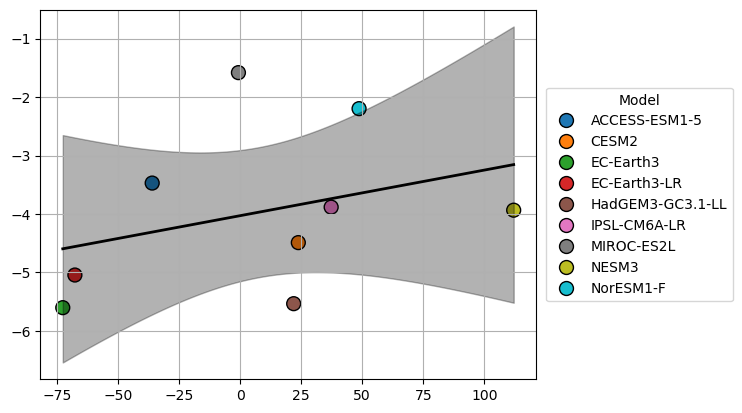

-4.02829483706124
positive_energy 

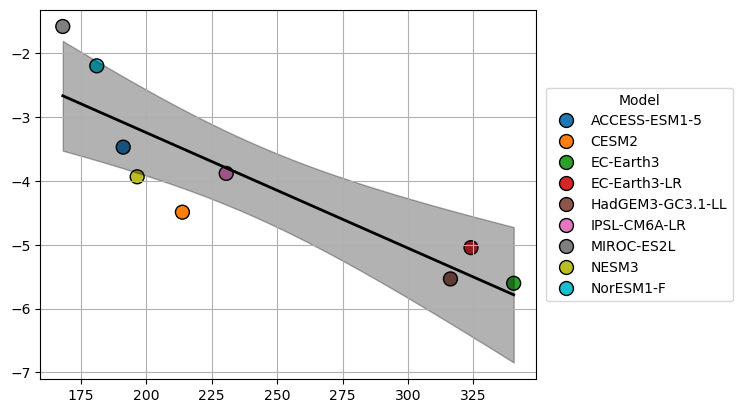

0.37565044120064917
max_energy 

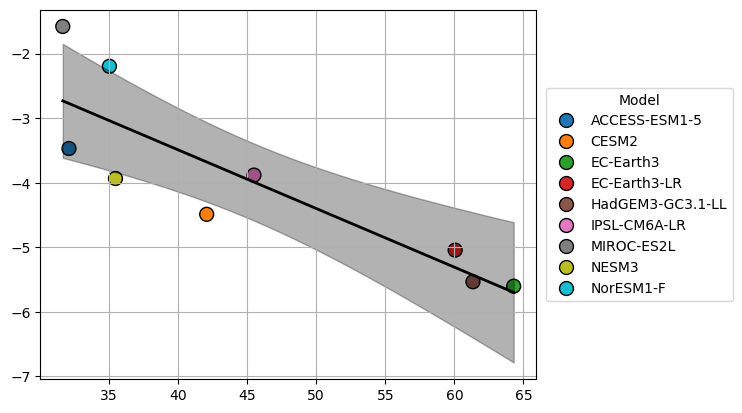

0.14056197145197782
melt_season_energy 

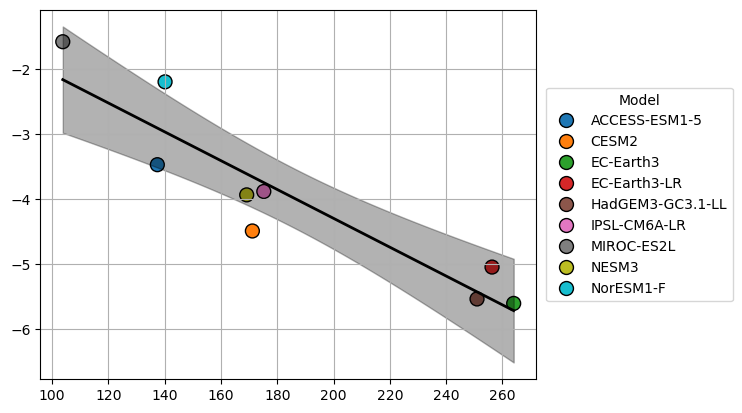

0.13484843126215126
melt_season_rsds 

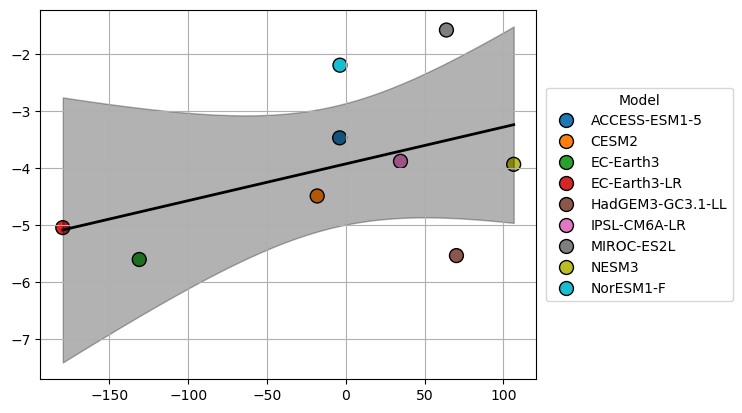

-3.9272821532622904
positive_rsds 

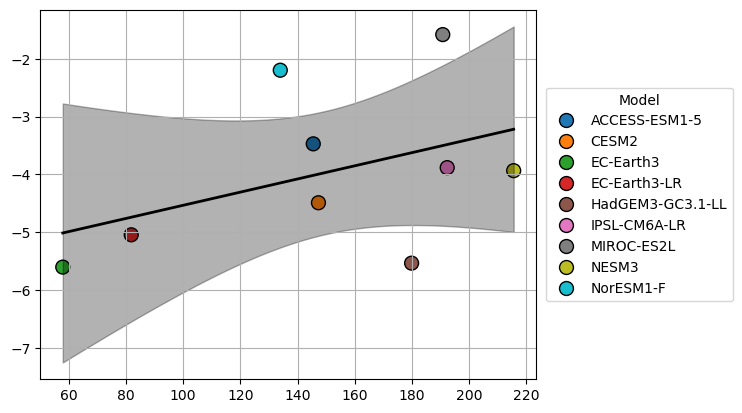

-5.671342597405539
positive_rlds 

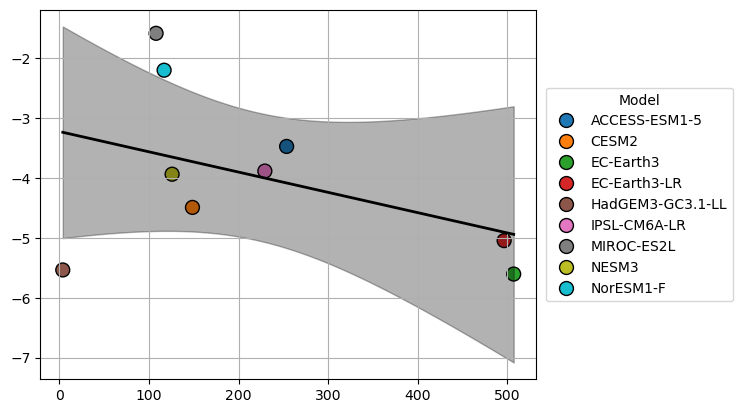

-3.2218807615578413
min_si 

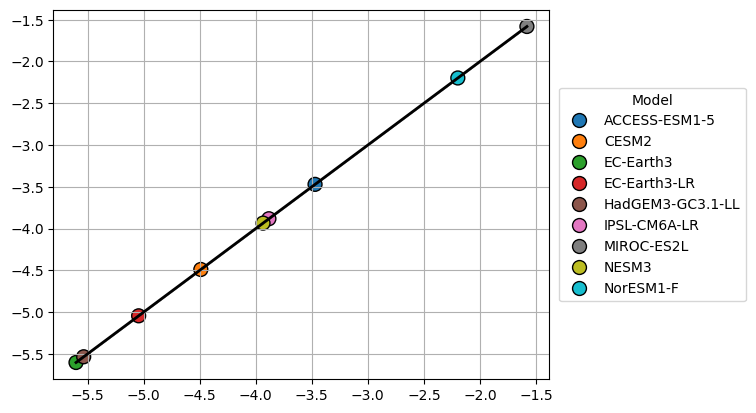

-1.1861007822670444e-15


In [31]:
labels = models
temp_dict = {}
for k, v in calculated_data.items():
    print(k, end =" ")
    x = np.array(v)
    y = np.array(min_si)
    stats_dict = scatter_models(x, y, labels)
    temp_dict[k] = stats_dict['intercept']
    print(stats_dict['intercept'])

In [32]:
temp_dict

{'total_energy': np.float64(-4.02829483706124),
 'positive_energy': np.float64(0.37565044120064917),
 'max_energy': np.float64(0.14056197145197782),
 'melt_season_energy': np.float64(0.13484843126215126),
 'melt_season_rsds': np.float64(-3.9272821532622904),
 'positive_rsds': np.float64(-5.671342597405539),
 'positive_rlds': np.float64(-3.2218807615578413),
 'min_si': np.float64(-1.1861007822670444e-15)}

In [33]:
x = np.array(melt_season_energy)
y = np.array(min_si)
labels = models

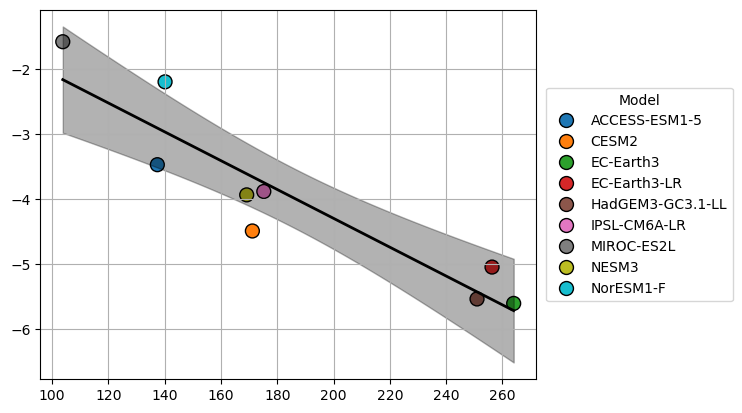

In [34]:
stats_dict = scatter_models(x, y, labels)

In [35]:
stats_dict

{'r_squared': np.float64(0.8503259484328541),
 'intercept': np.float64(0.13484843126215126),
 'slope': np.float64(-0.022154128847456243),
 'rmse': np.float64(0.5100804389355164)}

In [36]:
# Fit line
m, c = np.polyfit(x, y, 1)
y_fit = m * x + c

# RMSE
rmse = np.sqrt(np.mean((y - y_fit) ** 2))
print("RMSE:", rmse)

RMSE: 0.5100804389355165


In [37]:
R = np.full((13, 13), np.nan)

for n in range(13):
    for m in range(n, 13):
        melt_season_energy = []
        for model in models:
            melt_season_energy.append(
                np.trapz(energy_dict[model]['total'][n:m], dx=t_seconds) / 1e6
            )
        x = np.array(melt_season_energy)
        y = np.array(min_si)
        corr_matrix = np.corrcoef(x, y)
        pearson_r = corr_matrix[0, 1]

        # store the result at row n, column m
        R[n, m] = pearson_r


<Axes: >

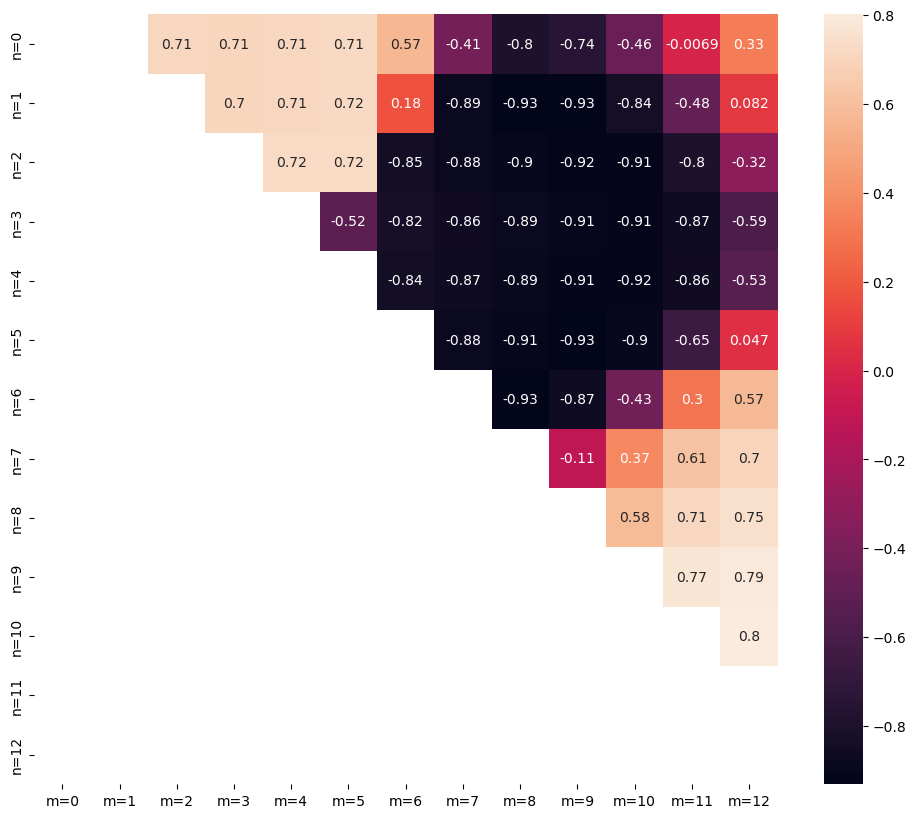

In [38]:
df = pd.DataFrame(
    R,
    index=[f"n={i}" for i in range(13)],
    columns=[f"m={j}" for j in range(13)]
)
plt.figure(figsize=(12,10))
sns.heatmap(df, annot = df)

In [39]:
#Here, we're going to create plots where there is one data point per year per model. 
#The anomalies must still be tekn from the piControl AVERAGE. 
#That can be got from the original code. 
if create:
    model_dict = {}
    for model in models:
        signed_cubes = []
        print(model)
        for var, sign in energy_variables_dict.items():
            print(var)
            # Construct filename
            path = create_path(model, experiment, var, root_path)
            
            # Load the single-cube file
            cube = get_cube(path, var, con, shape)
                    
            # Apply sign
            signed_cube = cube * sign
            signed_cubes.append(signed_cube)
            
            # Equalise attributes so summation won’t error on mismatched metadata
            iris.util.equalise_attributes(signed_cubes)
            
            # Sum them all
            net_flux = sum(signed_cubes)
            
            # Tidy up metadata
            net_flux.long_name = 'net_surface_energy_flux'
            #net_flux.standard_name = 'surface_net_downward_energy_flux'
            net_flux.units = signed_cubes[0].units
            model_dict[model] = net_flux
else:
    #%store -r model_dict
    with open(variable_storage, 'rb') as f:
        recovered = pickle.load(f)
        model_dict = recovered['model_dict'] 
        

KeyError: 'model_dict'

In [ ]:
if create:
    model_siconc_dict = {}
    for model in models:
        var = 'siconc'
        factor = si_variables_dict[var]
        path = create_path(model, experiment, var, root_path)
        cube = get_cube(path, var, con, shape)
        cube_scaled = cube / factor
        model_siconc_dict[model] = cube_scaled
else:
    #%store -r model_siconc_dict
    with open(variable_storage, 'rb') as f:
        recovered = pickle.load(f)
        model_siconc_dict = recovered['model_siconc_dict'] 

In [ ]:
if create:
    model_yearly_results_dict = {}
    for model in models:
        results_dict = {}
        
        net_flux = model_dict[model]
        siconc_cube = model_siconc_dict[model]
        
        season_cube = net_flux.extract(iris.Constraint(month_number=lambda m: 3 <= m < 10))
        area_weights = iris.analysis.cartography.area_weights(season_cube)
        area_mean = season_cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN, weights=area_weights)
        annual_sum = area_mean.aggregated_by('year',iris.analysis.SUM)
        annual_sum_anomaly = annual_sum - np.sum(control_energy_dict[model]['total'][2:9])
        
        area_weights = iris.analysis.cartography.area_weights(siconc_cube)
        min_siconc = (siconc_cube.collapsed(['latitude', 'longitude'], iris.analysis.SUM, weights=area_weights)).aggregated_by('year',iris.analysis.MIN)
        min_siconc_anomaly = min_siconc - np.min(control_si_dict[model]['siconc'])
    
        results_dict['melt_season_energy'] = annual_sum_anomaly.data
        results_dict['min_siconc'] = min_siconc_anomaly.data
        model_yearly_results_dict[model] = results_dict
else:
    #%store -r model_yearly_results_dict
    with open(variable_storage, 'rb') as f:
        recovered = pickle.load(f)
        model_yearly_results_dict = recovered['model_yearly_results_dict'] 

In [ ]:
for model in models:
    x = model_yearly_results_dict[model]['melt_season_energy']
    y = model_yearly_results_dict[model]['min_siconc']
    plt.scatter(x,y, label=model, s = 2.0)
plt.legend()
plt.show()

In [ ]:
if store:
    with open(variable_storage, 'wb') as f:
        pickle.dump({'experiment_energy_dict': experiment_energy_dict, 
                     'experiment_si_dict': experiment_si_dict,
                     'experiment_albedo_dict': experiment_albedo_dict,
                     'control_energy_dict': control_energy_dict, 
                     'control_si_dict': control_si_dict,
                     'control_albedo_dict': control_albedo_dict,
                     'anomaly_energy_dict': anomaly_energy_dict, 
                     'anomaly_si_dict': anomaly_si_dict,
                     'anomaly_albedo_dict': anomaly_albedo_dict,
                     'model_dict': model_dict, 
                     'model_siconc_dict': model_siconc_dict,
                     'model_yearly_results_dict': model_yearly_results_dict},
                    f)

In [ ]:
if add:
    with open(variable_storage, 'rb') as f:
        recovered = pickle.load(f)
        loaded_experiment_energy_dict = recovered['experiment_energy_dict'] 
        loaded_experiment_si_dict = recovered['experiment_si_dict'] 
        loaded_experiment_albedo_dict = recovered['experiment_albedo_dict']
        loaded_control_energy_dict = recovered['control_energy_dict'] 
        loaded_control_si_dict = recovered['control_si_dict'] 
        loaded_control_albedo_dict = recovered['control_albedo_dict']
        loaded_anomaly_energy_dict = recovered['anomaly_energy_dict'] 
        loaded_anomaly_si_dict = recovered['anomaly_si_dict'] 
        loaded_anomaly_albedo_dict = recovered['anomaly_albedo_dict']
        loaded_model_dict = recovered['model_dict']
        loaded_model_siconc_dict = recovered['model_siconc_dict']
        loaded_model_yearly_results_dict = recovered['model_yearly_results_dict']

    for model in models:
        loaded_experiment_energy_dict[model] = experiment_energy_dict[model]
        loaded_experiment_si_dict[model] = experiment_si_dict[model]
        loaded_experiment_albedo_dict[model] = experiment_albedo_dict[model] 
        loaded_control_energy_dict[model] = control_energy_dict[model] 
        loaded_control_si_dict[model] = control_si_dict[model]
        loaded_control_albedo_dict[model] = control_albedo_dict[model]
        loaded_anomaly_energy_dict[model] = anomaly_energy_dict[model]
        loaded_anomaly_si_dict[model] =  anomaly_si_dict[model]
        loaded_anomaly_albedo_dict[model] = anomaly_albedo_dict[model]
        loaded_model_dict[model] = model_dict[model]
        loaded_model_siconc_dict[model] = model_siconc_dict[model]
        loaded_model_yearly_results_dict[model] = model_yearly_results_dict[model]

    if store:
        with open(variable_storage, 'wb') as f:
            pickle.dump({'experiment_energy_dict': loaded_experiment_energy_dict, 
                         'experiment_si_dict': loaded_experiment_si_dict,
                         'experiment_albedo_dict': loaded_experiment_albedo_dict,
                         'control_energy_dict': loaded_control_energy_dict, 
                         'control_si_dict': loaded_control_si_dict,
                         'control_albedo_dict': loaded_control_albedo_dict,
                         'anomaly_energy_dict': loaded_anomaly_energy_dict, 
                         'anomaly_si_dict': loaded_anomaly_si_dict,
                         'anomaly_albedo_dict': loaded_anomaly_albedo_dict,
                         'model_dict': loaded_model_dict, 
                         'model_siconc_dict': loaded_model_siconc_dict,
                         'model_yearly_results_dict': loaded_model_yearly_results_dict},
                        f)